In [1]:
import numpy as np
import pandas as pd
import pygmo as pg
import sys
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
 
from keras.models import load_model
from sklearn.externals import joblib 

%load_ext line_profiler

C:\Users\JnJ\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df=pd.read_csv('training_data_randn.csv', nrows=10000)
cols_x = ['nPurchases', 'nPurchasesDiscount', 'AvgPrice', 'AvgService', 'AvgDiscount', 'CLV', 'Service', 'RRP', 'Discount']
col_y = 'is_deal'
col_p = 'Probability'
print(df.shape)

(10000, 22)


In [3]:
class predictor:
    def __init__(self, f_scalar_pickle, f_model_h5):
        self.f_scalar_pickle = f_scalar_pickle
        self.f_model_h5 = f_model_h5
        self.model = load_model(f_model_h5)
        self.scalar = joblib.load(f_scalar_pickle)
        
    def predict(self, X):
        X_s = self.scalar.transform(X)
        y = self.model.predict(X_s)[:, 0]
        return y
    
    def __copy__(self):
        newone = type(self)(self.f_scalar_pickle, self.f_model_h5)
        return newone
    
    def __deepcopy__(self, memo):
        newone = type(self)(self.f_scalar_pickle, self.f_model_h5)
        return newone
    
m = predictor('x_scalar_randn.pkl', 'elasticity_model_randn.h5')


In [33]:
%%timeit
m.predict(df[cols_x])

149 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
df.loc[:, 'pred'] = m.predict(df[cols_x])

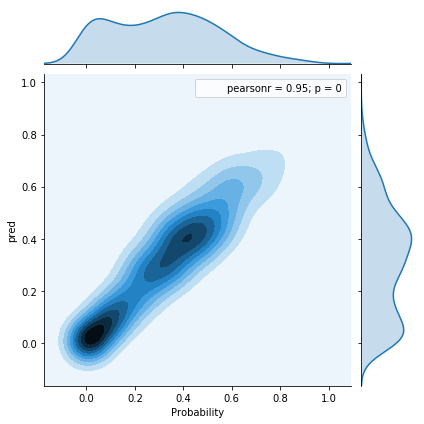

In [5]:
sns.jointplot(x=col_p, y='pred', data = df.iloc[:1000], kind="kde")

# Background

Linear programming vs non-linear programming

Optimization algorithms: local vs heuristic

# User Defined Problem (UDP)

## Single-objective optimization

Find out the discount amount for each product in order to maximize revenue

In [6]:
# class optimal_discount_per_product_for_max_revenue:
#     def __init__(self, df, model): 
#         self.cols_x = ['nPurchases', 'nPurchasesDiscount', 'AvgPrice', 'AvgService', 'AvgDiscount', 'CLV', 'Service', 'RRP', 'Discount']
#         self.df_X = df[self.cols_x+ ['product_id',]]     
#         self.p_ids = df['product_id'].unique()
#         self.n_products = len(self.p_ids)
#         self.max_discounts_ratio = (df.Discount/df.RRP).max()
#         self.model = model
        
#     def fitness(self, dv): # fitness given decision vector (dv)
#         prod_discount = dict(zip(self.p_ids, dv))
#         v_dis = self.df_X['product_id'].map(prod_discount) * self.df_X['RRP']
#         X = self.df_X[self.cols_x].values
#         X[:, -1] = v_dis
#         y = self.model.predict(self.df_X[self.cols_x])
#         return y
        
#     def get_bounds(self): # box bounds of decision vector (dv)
#         return ([0,]*self.n_products, [self.max_discounts_ratio, ]*self.n_products)

In [7]:
class optimal_discount_per_product_for_max_revenue:
    def __init__(self, df, model): 
        cols_x = ['nPurchases', 'nPurchasesDiscount', 'AvgPrice', 'AvgService', 'AvgDiscount', 'CLV', 'Service', 'RRP', 'Discount']
        self.X = df[cols_x].values     
        self.x_products_id = df['product_id']
        self.p_ids = df['product_id'].unique()
        self.n_products = len(self.p_ids)
        self.max_discounts_ratio = (df.Discount/df.RRP).max()
        self.model = predictor('x_scalar_randn.pkl', 'elasticity_model_randn.h5')
        
    def fitness(self, dv): # fitness given decision vector (dv)
        prod_discount = dict(zip(self.p_ids, dv))
        self.X[:, -1] = self.x_products_id.map(prod_discount) * self.X[:, -2]
        y_prob = self.model.predict(self.X)
        revenue = y_prob.dot(self.X[:, -2] - self.X[:, -1])  
        return [-revenue,]
    
    def get_bounds(self): # box bounds of decision vector (dv)       
        return ([0,]*self.n_products, [self.max_discounts_ratio, ]*self.n_products)

In [8]:
pp_rev = optimal_discount_per_product_for_max_revenue(df, m)

In [9]:
for v in np.arange(0, 0.2, 0.02):
    print(v, round(-pp_rev.fitness([v,]*5)[0]))

0.0 3279111.0
0.02 3194013.0
0.04 3151852.0
0.06 3219784.0
0.08 3500566.0
0.1 3918792.0
0.12 4237974.0
0.14 4379165.0
0.16 4393400.0
0.18 4335283.0


In [10]:
prob = pg.problem(pp_rev)
algo = pg.algorithm(pg.de(gen = 100))
pop = pg.population(prob,10)


In [11]:
pop = algo.evolve(pop)

In [12]:
best_x_rev = pop.champion_x
best_f_rev = pop.champion_f
print(best_x_rev, best_f_rev) 

[0.15347458 0.1616868  0.16135997 0.12678191 0.19991756] [-4441582.74040853]


## Multi-objective optimization

In [13]:
class optimal_discount_per_product_for_max_revenue_min_cost:
    def __init__(self, df, model): 
        cols_x = ['nPurchases', 'nPurchasesDiscount', 'AvgPrice', 'AvgService', 'AvgDiscount', 'CLV', 'Service', 'RRP', 'Discount']
        self.X = df[cols_x].values     
        self.x_products_id = df['product_id']
        self.x_cost = df['Cost']
        self.p_ids = df['product_id'].unique()
        self.n_products = len(self.p_ids)
        self.max_discounts_ratio = (df.Discount/df.RRP).max()
        self.model = predictor('x_scalar_randn.pkl', 'elasticity_model_randn.h5')
    
    def get_nobj(self):
        return 2
    
    def fitness(self, dv): # fitness given decision vector (dv)
        prod_discount = dict(zip(self.p_ids, dv))
        self.X[:, -1] = self.x_products_id.map(prod_discount) * self.X[:, -2]
        y_prob = self.model.predict(self.X)
        revenue = y_prob.dot(self.X[:, -2] - self.X[:, -1])  
        cost = y_prob.dot(self.x_cost)
        return [-revenue,-cost]
    
    def get_bounds(self): # box bounds of decision vector (dv)       
        return ([0,]*self.n_products, [self.max_discounts_ratio, ]*self.n_products)

In [14]:
pp_rev_cost = optimal_discount_per_product_for_max_revenue_min_cost(df, m)

In [15]:
for v in np.arange(0, 0.2, 0.02):
    print(v, -np.asarray(pp_rev_cost.fitness([v,]*5)).round())

0.0 [ 3279111. -1312194.]
0.02 [ 3194013. -1302610.]
0.04 [ 3151852. -1311725.]
0.06 [ 3219784. -1372697.]
0.08 [ 3500566. -1537609.]
0.1 [ 3918792. -1764603.]
0.12 [ 4237974. -1939883.]
0.14 [ 4379165. -2037403.]
0.16 [ 4393400. -2084175.]
0.18 [ 4335283. -2102531.]


In [ ]:
prob = pg.problem(pp_rev_cost)
pop = pg.population(prob,32)

In [ ]:
algo = pg.algorithm(pg.nsga2(gen = 100))
algo.set_verbosity(5)

In [43]:
pop = algo.evolve(pop)

In [53]:
fits, vectors = -pop.get_f(), pop.get_x()
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(fits)

In [54]:
idx_sorted = fits.argsort(0)[:, 0]

In [36]:
fits[idx_sorted]

array([[ 3225888.94671196, -1331445.90387373],
       [ 3254914.84181603, -1348303.4450137 ],
       [ 3311514.00660312, -1380264.33511535],
       [ 3327578.56825368, -1391720.18037801],
       [ 3408973.81305962, -1404316.9582921 ],
       [ 3431591.45466606, -1409531.42205169],
       [ 3464226.30121756, -1438878.36870918],
       [ 3515787.16696368, -1454511.04253808],
       [ 3553057.63193307, -1475924.08432305],
       [ 3597013.7185158 , -1495381.35340872],
       [ 3668096.31238548, -1532683.24449509],
       [ 3720921.73505964, -1565400.16778368],
       [ 3811153.52616482, -1600491.64105983],
       [ 3827908.99386521, -1608657.28262712],
       [ 3853915.50866017, -1628996.39384512],
       [ 3900525.20074554, -1642327.80196583],
       [ 3934017.96199277, -1658153.78675561],
       [ 3991001.92051645, -1700490.06447558],
       [ 3999015.88194176, -1705871.63126775],
       [ 4031443.13873356, -1732846.06020987],
       [ 4053837.12897152, -1765747.23211229],
       [ 4070

In [37]:
vectors[idx_sorted]

array([[0.01336855, 0.07352044, 0.03013724, 0.01469742, 0.06489632],
       [0.01336855, 0.07752961, 0.02840276, 0.01469742, 0.09109924],
       [0.01336855, 0.07326873, 0.0862368 , 0.0151557 , 0.0628068 ],
       [0.01336855, 0.07547786, 0.08450299, 0.0151557 , 0.08900972],
       [0.01359921, 0.11322162, 0.02831257, 0.01926868, 0.089967  ],
       [0.01359921, 0.11518763, 0.01986803, 0.01333868, 0.089967  ],
       [0.01360446, 0.11322162, 0.07741655, 0.01926868, 0.08991555],
       [0.00484335, 0.12079507, 0.07741778, 0.01351247, 0.09017181],
       [0.01315189, 0.14495218, 0.0317102 , 0.01462934, 0.1333412 ],
       [0.02059048, 0.13480538, 0.08890731, 0.00968977, 0.09001338],
       [0.00346896, 0.16447819, 0.11190176, 0.0336872 , 0.02607583],
       [0.00771009, 0.14946134, 0.15235046, 0.03126924, 0.01543901],
       [0.13408248, 0.17815858, 0.02840276, 0.0018673 , 0.09109924],
       [0.14190773, 0.16443612, 0.07466383, 0.01402286, 0.04115673],
       [0.14205963, 0.16537263, 0.

In [45]:
log = algo.extract(pg.nsga2).get_log()

## Optimization with constraint

## Integer problem

## Optimization with gradient/hessian

## Logging during training

log = algo.extract(pg.nlopt).get_log()
from matplotlib import pyplot as plt 
plt.semilogy([line[0] for line in log], [line[1] for line in log], label = "obj") 
plt.semilogy([line[0] for line in log], [line[3] for line in log], label = "con")
